In [2]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.externals import joblib
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

In [4]:
ls

data_exp.ipynb*                    __init__.py*         __pycache__/
equipment_failure_notebook.ipynb*  model_list.pkl*      thresh_losses.json*
frag_tools.py*                     new_explore.ipynb*   Untitled.ipynb*
initial_data_cleaning.ipynb*       profit_curve.ipynb*  various_tools.py*


In [74]:
from frag_tools import (DropColumns,
                        AddressLatLong,
                        CurrentMakeDummies,
                        Binarize,
                        ChangeTypes,
                        custom_zip_cleaning)
from various_tools import (roc,
                           plot_roc,
                           cross_val_metrics,
                           make_metric_df)

In [6]:
df = pd.read_csv('/mnt/c/Users/kurtrm/Downloads/Predictive_Maintenance_Transformer_Overload_PA.csv', sep=';')

In [7]:
pipe = make_pipeline(CurrentMakeDummies(['Manufacturer',
                                         'Repairs',
                                         'Overloads',
                                         'AssetType']),
                     ChangeTypes(['Age', 'AssetZip'],
                                 [lambda x: float(x.replace(',', '.')),
                                  custom_zip_cleaning]),
                     Binarize(['VegMgmt',
                               'PMLate',
                               'WaterExposure',
                               'MultipleConnects',
                               'Storm']),
                     AddressLatLong(),
                     DropColumns(['AssetCity',
                                  'AssetId',
                                  'AvgRepairCost',
                                  'AssetState',
                                  'MilesFromOcean',
                                  'AssetLocation',
                                  'locationID',
                                  'Latitude1',
                                  'Longitude1',
                                  'AssetZip']))
transformed = pipe.fit_transform(df)

In [8]:
transformed.head()

,VegMgmt,PMLate,WaterExposure,MultipleConnects,Storm,Age,Latitude,Longitude,Status,Manufacturer_GE,...,Repairs_Rebuild+3,Overloads_100-120%,Overloads_120-150%,Overloads_Above 150%,Overloads_Below 100%,AssetType_1-Phase Pole Transformer,AssetType_3-Phase Transformer,AssetType_DF-series Transformer,AssetType_Padmount Transformer,AssetType_Voltage Transformer
0,1,0,0,1,0,70.3,33.516805,-84.258478,1,0,...,1,0,0,0,1,1,0,0,0,0
1,1,0,0,0,0,70.3,33.959887,-84.435503,1,0,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,70.3,33.932735,-84.259163,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1,0,0,1,0,70.3,33.555964,-84.257573,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1,0,0,0,0,70.3,33.478919,-84.354102,0,0,...,0,0,0,1,0,1,0,0,0,0


In [9]:
# For later use
lat_longs_status = transformed[['Latitude', 'Longitude', 'Status']]

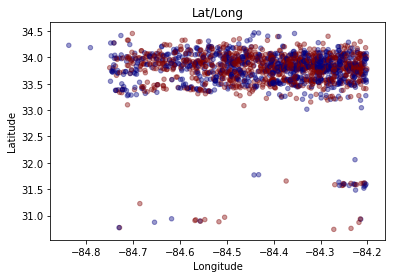

In [10]:
lat_longs_status.plot(kind='scatter', x='Longitude', y='Latitude', alpha=.4,
                      c='Status', cmap=plt.get_cmap("jet"), title='Lat/Long',
                      colorbar=False)

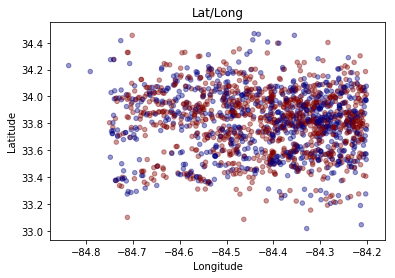

In [11]:
lat_longs_status[lat_longs_status['Latitude'] > 33].plot(kind='scatter', x='Longitude', y='Latitude', alpha=.4,
                      c='Status', cmap=plt.get_cmap("jet"), title='Lat/Long',
                      colorbar=False)

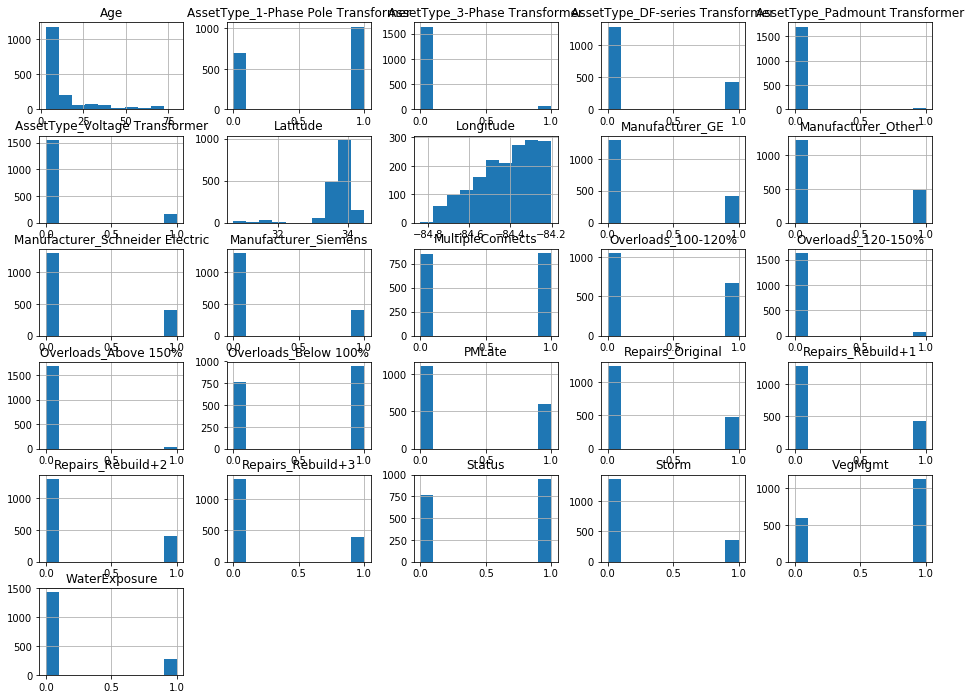

In [12]:
transformed.hist(figsize=(16, 12));

In [13]:
train, test = train_test_split(transformed.drop(['Latitude', 'Longitude'], axis=1), test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(train.drop('Status', axis=1).values,
                                                    train['Status'].values, test_size=.2)

In [14]:
log_reg = LogisticRegression()
rfc = RandomForestClassifier(50)
gbc = GradientBoostingClassifier(learning_rate=.005, subsample=.5, n_estimators=250)
log_reg.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [15]:
metrics = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
make_metric_df([log_reg, rfc, gbc], X_test, y_test, metrics)

,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier
average_precision,1.000000,1.000000,1.000000
f1,1.000000,1.000000,1.000000
neg_log_loss,-0.148695,-0.043076,-0.035002
recall,1.000000,1.000000,1.000000
roc_auc,1.000000,1.000000,1.000000


In [16]:
X_train.shape, X_test.shape

((1097, 23), (275, 23))

In [17]:
rfc.feature_importances_.shape

(23,)

In [18]:
rfc_features = pd.DataFrame(rfc.feature_importances_,
                        index=train.drop('Status', axis=1).columns,
                        columns=['Importance'])

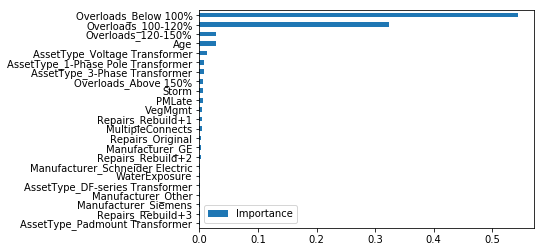

In [19]:
rfc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [20]:
gbc_features = pd.DataFrame(gbc.feature_importances_,
                            index=train.drop('Status', axis=1).columns,
                            columns=['Importance'])

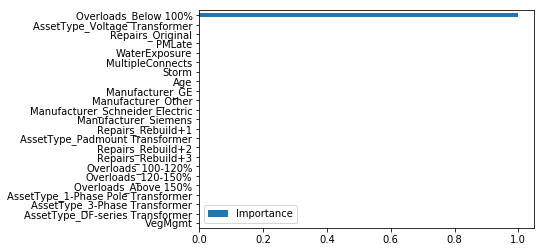

In [21]:
gbc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [22]:
logreg_features = pd.DataFrame(log_reg.coef_.flatten(),
                               index=train.drop('Status', axis=1).columns,
                               columns=['Importance'])

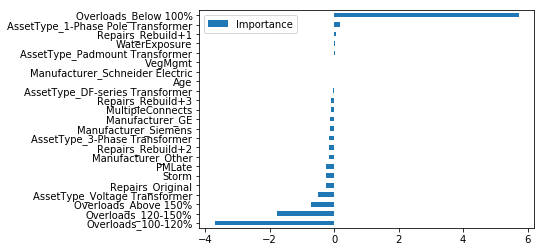

In [23]:
logreg_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [24]:
transformed[['Overloads_Below 100%', 'Status']].sum()

Overloads_Below 100%    950
Status                  950
dtype: int64

### Data Leakage in "Overloads_Below 100%"
So...if a transformer has ever been overloaded, it is a "problem transformer."
From [this](https://www.hammondpowersolutions.com/faq/what-is-the-effect-of-overload/) website:
> _Overload is when a transformer is subjected to voltages and/or currents that exceed its design specifications. During overloading conditions, excess heat will cause the insulation system to break down, resulting in decreased life expectancy of the transformer._

This column correlates perfectly with Y, so if we wanted to determine which transformers to service beyond this one, we'll have to remake the models on all other columns.

But there may still be data leakage in the other 'overload' columns, so I should probably drop those as well.

In [25]:
train, test = train_test_split(transformed.drop(['Latitude', 'Longitude', 'Overloads_Below 100%',
                                                 'Overloads_100-120%', 'Overloads_120-150%', 'Overloads_Above 150%'], axis=1), test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(train.drop('Status', axis=1).values,
                                                    train['Status'].values, test_size=.2)

In [26]:
log_reg = LogisticRegression()
rfc = RandomForestClassifier(50)
gbc = GradientBoostingClassifier(learning_rate=.005, subsample=.5, n_estimators=250)
log_reg.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [27]:
metrics = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
make_metric_df([log_reg, rfc, gbc], X_test, y_test, metrics)

,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier
average_precision,0.808340,0.726638,0.815958
f1,0.756948,0.734265,0.734687
neg_log_loss,-0.605106,-0.651065,-0.605897
recall,0.879323,0.818895,0.782888
roc_auc,0.739434,0.654996,0.741166


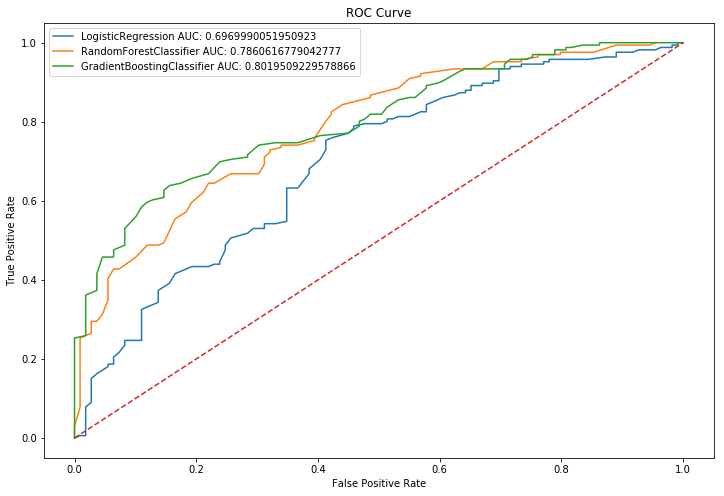

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
for model in [log_reg, rfc, gbc]:
    plot_roc(model, X_test, y_test, ax)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    legend_data = '{} AUC: {}'.format(model.__class__.__name__, auc_score)
    legend.append(legend_data)
ax.legend(legend)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

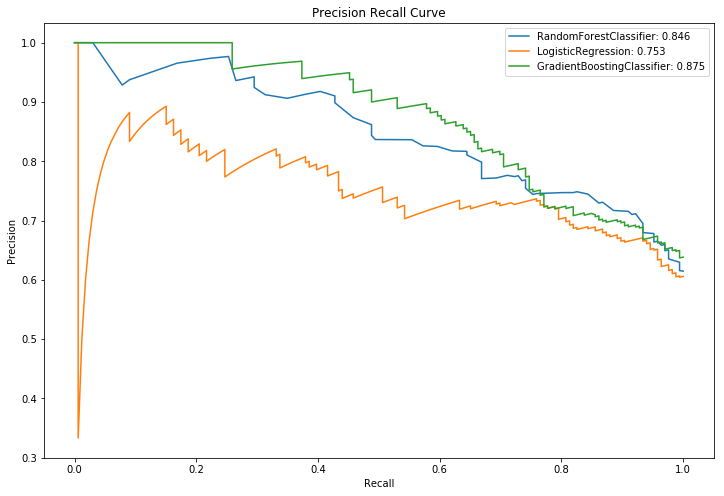

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
for mod in [rfc, log_reg, gbc]:
    precision, recall, threshold = precision_recall_curve(y_test, mod.predict_proba(X_test)[:, 1])
    avg_prec = average_precision_score(y_test, mod.predict_proba(X_test)[:, 1])
    ax.plot(recall, precision, label=f'{mod.__class__.__name__}: {avg_prec:.3f}')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title('Precision Recall Curve')
ax.legend();

In [30]:
rfc_features = pd.DataFrame(rfc.feature_importances_,
                        index=train.drop('Status', axis=1).columns,
                        columns=['Importance'])

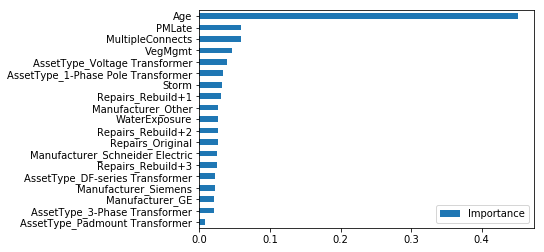

In [31]:
rfc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [32]:
gbc_features = pd.DataFrame(gbc.feature_importances_,
                            index=train.drop('Status', axis=1).columns,
                            columns=['Importance'])

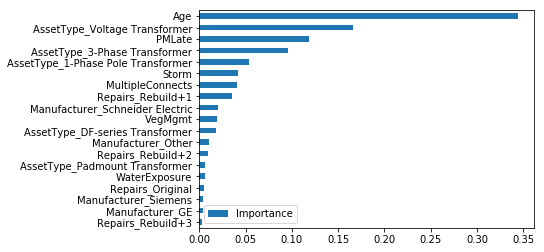

In [33]:
gbc_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

In [34]:
logreg_features = pd.DataFrame(log_reg.coef_.flatten(),
                               index=train.drop('Status', axis=1).columns,
                               columns=['Importance'])

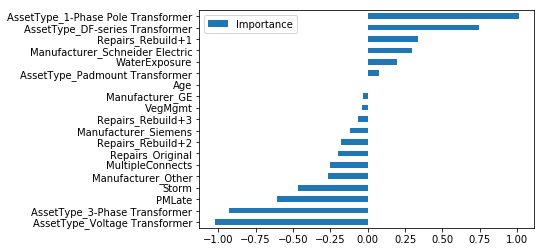

In [35]:
logreg_features.sort_values(by='Importance', ascending=True).plot(kind='barh')

### Initial Assessment
Age is a continuous feature, so it shows up much stronger in the forest models. Made some shitty models, next I'll do some cross validation.

In [36]:
logreg_params = {'penalty': ['l1', 'l2'],
                 'C': [1.0, 10.0, 100.0, 1000.0]}
sgd_params = {'loss': ['log'],
              'penalty': ['elasticnet'],
              'alpha': [.0001, .0005, .001, .005],
              'l1_ratio': [.15, .3, .45, .6, .75],
              'n_jobs': [-1]}
rfc_params = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'oob_score': [False, True],
              'n_jobs': [-1]}
ext_params_1 = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'bootstrap': [False],
              'oob_score': [False],
              'n_jobs': [-1]}
ext_params_2 = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 3, 5],
              'bootstrap': [True],
              'oob_score': [True],
              'n_jobs': [-1]}
gbc_params = {'n_estimators': [500],
              'learning_rate': [.005, .0001, .0005, .00001],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 3, 5],
              'max_features': ['sqrt', 'log2']}

In [37]:
def grid_search_models(models: list, param_dicts: list, X: np.ndarray, y: np.ndarray) -> list:
    """
    Return a list of grid search objects.
    models should contain a list of model class references.
    models and param_dicts will be zipped, so ensure they
    are ordered with each other.
    """
    grid_searched_models = []
    for model, params in zip(models, param_dicts):
        search = GridSearchCV(model(),
                              params, cv=10, refit=True, verbose=True)
        search.fit(X_train, y_train)
        grid_searched_models.append(search)
    
    return grid_searched_models

In [38]:
# model_reflist = [LogisticRegression,
#                  SGDClassifier,
#                  RandomForestClassifier,
#                  ExtraTreesClassifier,
#                  ExtraTreesClassifier,
#                  GradientBoostingClassifier]
# params_list = [logreg_params, sgd_params, rfc_params, ext_params_1, ext_params_2, gbc_params]
# scores = ['average_precision', 'f1', 'roc_auc', 'neg_log_loss', 'recall']
# models = grid_search_models(model_reflist, params_list, X_train, y_train)

In [39]:
# joblib.dump(models, 'model_list.pkl')

In [40]:
model_list = joblib.load('model_list.pkl')

In [41]:
besties = [clone(mod.best_estimator_) for mod in model_list]

In [42]:
make_metric_df(besties, X_train, y_train, metrics)

/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kurtrm/anaco

,ExtraTreesClassifier,GradientBoostingClassifier,LogisticRegression,RandomForestClassifier,SGDClassifier
average_precision,0.698172,0.802734,0.688711,0.767177,0.663337
f1,0.674751,0.727576,0.700424,0.716213,0.661196
neg_log_loss,-0.630426,-0.577759,-0.634725,-0.593575,-2.801328
recall,0.726407,0.800280,0.786561,0.740112,0.664014
roc_auc,0.698695,0.776298,0.688372,0.744732,0.695884


### Model Assessment

I don't know a whole lot about ExtraTreesClassifier, but my broad understanding is that it increases the randomness of the trees by randomizing the threshold at each split. A learning opportunity.

GradientBoosting outperforms the other models on all metrics. Still, random forest is a close second, and it may be worth investing some time to improve a logistic regression model.

I've heard of elastic net regression which combines l1 and l2 regularization, so I wanted to see if I could use it in the logistic regression model. The way to do this was to use sklearn's SGDClassifier and change the loss to 'log' and metric to 'elasticnet.' This seems to perform worse than l2 regularization at all tested points of l1_ratio.

Lastly, there seemed to be some consensus that if your data is somewhat sparse, it's worth observing a log reg's performance with l1 regularization (since this data is somewhat sparse). l2 still proved to be a better choice.

In [43]:
make_metric_df([besties[3]], X_train, y_train, metrics)

,ExtraTreesClassifier
average_precision,0.701282
f1,0.667847
neg_log_loss,-0.718256
recall,0.700604
roc_auc,0.687043


/home/kurtrm/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


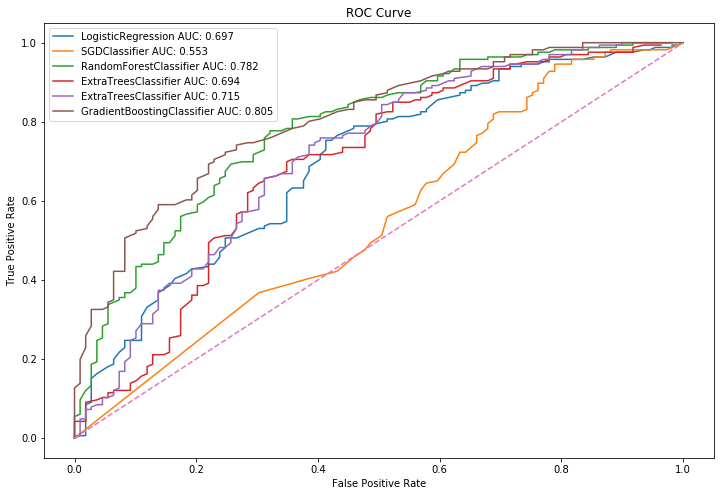

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
for a_model in besties:
    a_model.fit(X_train, y_train)
    plot_roc(a_model, X_test, y_test, ax)
    auc_score = roc_auc_score(y_test, a_model.predict_proba(X_test)[:, 1])
    legend_data = '{} AUC: {:.3f}'.format(a_model.__class__.__name__, auc_score)
    legend.append(legend_data)
ax.legend(legend)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

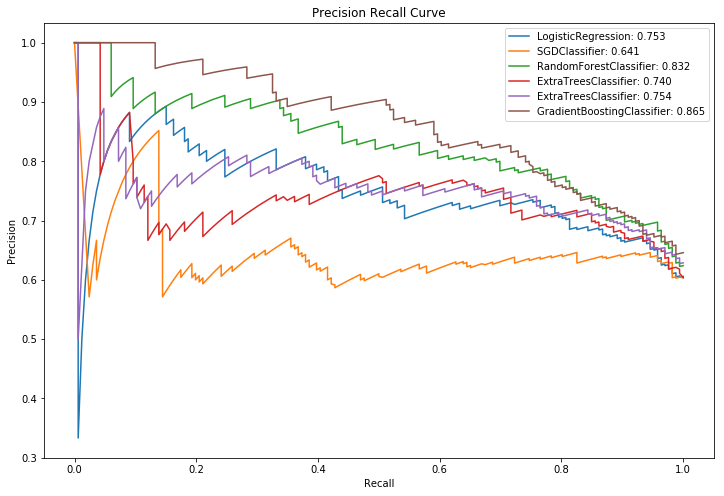

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))
for a_mod in besties:
    precision, recall, threshold = precision_recall_curve(y_test, a_mod.predict_proba(X_test)[:, 1])
    avg_prec = average_precision_score(y_test, a_mod.predict_proba(X_test)[:, 1])
    ax.plot(recall, precision, label=f'{a_mod.__class__.__name__}: {avg_prec:.3f}')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title('Precision Recall Curve')
ax.legend();

I'll work on some fine tuning of the random forest and gradient boosting classifier. In the meantime, I'm curious to see if a KNN model can make any decent prediction on lat/longs.

In [47]:
ll_X_train, ll_X_test, ll_y_train, ll_y_test = train_test_split(lat_longs_status.drop('Status', axis=1).values, lat_longs_status['Status'].values, test_size=.2)

In [48]:
knn = KNeighborsClassifier()
knn.fit(ll_X_train, ll_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [49]:
make_metric_df([KNeighborsClassifier(n_neighbors=3)], ll_X_train, ll_y_train, metrics)

,KNeighborsClassifier
average_precision,0.580703
f1,0.587396
neg_log_loss,-4.369915
recall,0.602649
roc_auc,0.539684


In [57]:
initial = make_metric_df([KNeighborsClassifier(n_neighbors=3)], ll_X_train, ll_y_train, metrics)
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(4, 31):
    metric_df = make_metric_df([KNeighborsClassifier(n_neighbors=i)], ll_X_train, ll_y_train, metrics)
    metric_df.columns = ['KNeighborsClassifier' + f'_{i}']
    initial = pd.concat([initial, metric_df], axis=1)

In [62]:
initial.idxmax(axis=1)

average_precision       KNeighborsClassifier
f1                   KNeighborsClassifier_29
neg_log_loss         KNeighborsClassifier_29
recall               KNeighborsClassifier_29
roc_auc                 KNeighborsClassifier
dtype: object

In [64]:
initial[['KNeighborsClassifier', 'KNeighborsClassifier_29']]

,KNeighborsClassifier,KNeighborsClassifier_29
average_precision,0.580703,0.558883
f1,0.587396,0.625208
neg_log_loss,-4.369915,-0.705871
recall,0.602649,0.727152
roc_auc,0.539684,0.499676


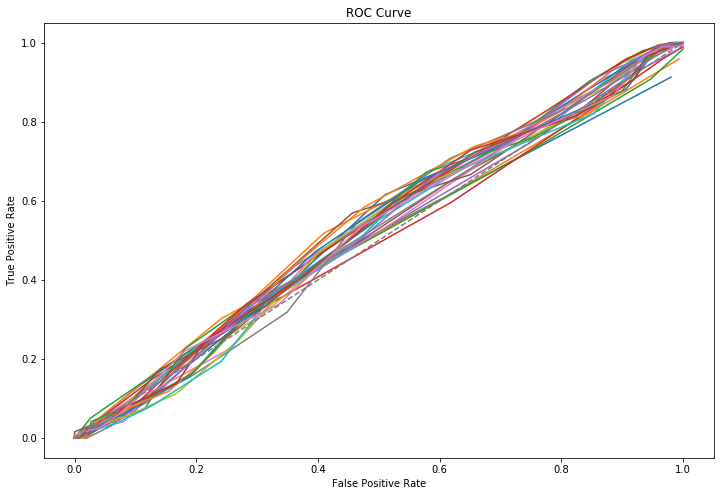

In [91]:
fig, ax = plt.subplots(figsize=(12, 8))
legend = []
for i in range(4, 31):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(ll_X_train, ll_y_train)
    roc_plot = plot_roc(knn, ll_X_test, ll_y_test, ax)
    auc_score = roc_auc_score(ll_y_test, knn.predict_proba(ll_X_test)[:, 1].reshape(-1, 1))
    legend_data = '{} AUC: {:.3f}'.format(knn.__class__.__name__ + f'_{i}', auc_score)
    legend.append(legend_data)
dashed_line = np.linspace(0, 1, 100)
ax.plot(dashed_line, dashed_line, '--');

Nice...

In [80]:
ll_X_train.shape

(1372, 2)

In [88]:
ll_X_test[:, 1].shape

(344,)

In [87]:
knn.predict_proba().shape

ValueError: Expected 2D array, got 1D array instead:
array=[-84.3380797 -84.458409  -84.4947076 -84.6135497 -84.2825425 -84.5764437
 -84.2290202 -84.4043395 -84.2126259 -84.5477315 -84.5426544 -84.378502
 -84.4218211 -84.5317004 -84.6973864 -84.3148123 -84.2724243 -84.4026978
 -84.65994   -84.5345536 -84.4904233 -84.2270768 -84.4381181 -84.372963
 -84.526695  -84.3251353 -84.5646809 -84.7003878 -84.443994  -84.2051726
 -84.312748  -84.7027562 -84.4480133 -84.2413185 -84.4031287 -84.6764132
 -84.208421  -84.3052817 -84.3972592 -84.586819  -84.2566776 -84.4420662
 -84.560333  -84.275229  -84.3330256 -84.3242311 -84.334515  -84.4759263
 -84.41311   -84.6569443 -84.3595086 -84.3443    -84.3063094 -84.2361532
 -84.6499355 -84.309283  -84.237855  -84.2729179 -84.2927001 -84.3568749
 -84.740191  -84.5848338 -84.4574864 -84.4227537 -84.462558  -84.4136144
 -84.2259654 -84.2026399 -84.2205929 -84.427646  -84.4517658 -84.653148
 -84.2142317 -84.5452135 -84.2437461 -84.415445  -84.471407  -84.2931157
 -84.3346076 -84.2044314 -84.480411  -84.7306176 -84.333865  -84.335226
 -84.4789796 -84.278614  -84.6465837 -84.700916  -84.501983  -84.2239553
 -84.692216  -84.3245599 -84.5774684 -84.5445832 -84.3614958 -84.2208816
 -84.304933  -84.2895338 -84.4089361 -84.375569  -84.4483004 -84.2727724
 -84.3725022 -84.2570792 -84.5220855 -84.2507128 -84.4239752 -84.568096
 -84.3361896 -84.2127082 -84.391249  -84.340997  -84.213317  -84.3303324
 -84.324274  -84.2458455 -84.597547  -84.2065702 -84.2594655 -84.3423102
 -84.2341158 -84.2429647 -84.2746661 -84.4395232 -84.6035129 -84.6930576
 -84.2763937 -84.6584473 -84.296036  -84.2446521 -84.7451246 -84.5465001
 -84.3355907 -84.2066345 -84.237467  -84.2265829 -84.2519564 -84.4966336
 -84.2677759 -84.647441  -84.376904  -84.4246119 -84.524292  -84.3491316
 -84.2594904 -84.5310247 -84.3055694 -84.4369184 -84.4848899 -84.7027153
 -84.22147   -84.7144331 -84.7013883 -84.210996  -84.2053443 -84.5151528
 -84.6760455 -84.2583135 -84.2671177 -84.7281008 -84.283954  -84.5619572
 -84.2699768 -84.2218326 -84.2554388 -84.505905  -84.6126909 -84.4021026
 -84.550883  -84.2951115 -84.2721449 -84.235186  -84.3443249 -84.4524835
 -84.3322312 -84.2350464 -84.4572403 -84.3722148 -84.539522  -84.2716997
 -84.3673159 -84.3584974 -84.308878  -84.4542263 -84.326286  -84.343873
 -84.721622  -84.2720952 -84.6845011 -84.4406056 -84.6354788 -84.3633029
 -84.4478493 -84.3217436 -84.350546  -84.2868402 -84.7053286 -84.285956
 -84.4023079 -84.3999131 -84.2944889 -84.719519  -84.257892  -84.243764
 -84.2472035 -84.4774117 -84.3432362 -84.2256772 -84.4996696 -84.4828224
 -84.7321419 -84.2962981 -84.3764504 -84.5551006 -84.5292793 -84.2121318
 -84.2205723 -84.4182719 -84.4484644 -84.2304112 -84.3673278 -84.314492
 -84.4989284 -84.4789079 -84.2767634 -84.2220544 -84.318743  -84.6704691
 -84.427083  -84.2522914 -84.3145516 -84.3986548 -84.514428  -84.6889123
 -84.558307  -84.206058  -84.2760646 -84.2877894 -84.4083485 -84.3426717
 -84.2353506 -84.3689705 -84.2361003 -84.3455164 -84.3077574 -84.260484
 -84.417164  -84.6432324 -84.5122852 -84.5065905 -84.2379642 -84.2838423
 -84.2290528 -84.240132  -84.2537463 -84.473721  -84.4797072 -84.5551211
 -84.6119139 -84.622035  -84.4751366 -84.586298  -84.2407423 -84.473129
 -84.2729939 -84.4821256 -84.2390137 -84.4067815 -84.6819278 -84.5719952
 -84.414897  -84.3706748 -84.5316185 -84.4444041 -84.2838586 -84.452273
 -84.3073167 -84.63427   -84.4601517 -84.5289565 -84.289784  -84.2086729
 -84.670612  -84.3921521 -84.5734989 -84.3896139 -84.4733124 -84.4319331
 -84.4929045 -84.4412096 -84.335923  -84.5584574 -84.2187196 -84.4693147
 -84.2490553 -84.276591  -84.5671553 -84.4157073 -84.3116125 -84.2393018
 -84.5001167 -84.52382   -84.467851  -84.5907254 -84.4935602 -84.2884459
 -84.4006455 -84.5454182 -84.2216839 -84.283351  -84.2108475 -84.6741867
 -84.2972232 -84.3049789 -84.4877817 -84.440854  -84.2492199 -84.358512
 -84.563603  -84.3181054 -84.2260271 -84.582747  -84.4464958 -84.2142317
 -84.2398575 -84.3739547 -84.5579662 -84.3978544 -84.5193106 -84.3591135
 -84.2608708 -84.2566471 -84.4954043 -84.4057349 -84.5786551 -84.215412
 -84.3420731 -84.4152659 -84.4794749 -84.2580264 -84.4882173 -84.2815966
 -84.2185961 -84.3464119].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.